In [1]:
import torch
import torch.nn as nn
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

from torch.utils.data import Dataset, DataLoader
# from torch.utils.data.sampler import Sampler
import torch.optim as optim
import sys
sys.path.append('../')

from dataset import LbpDataset, train_transforms, val_transforms, test_transforms, collate_fn, get_data
from visualize import visualize
# from rcnn_model import fasterrcnn_resnet201_fpn, FastRCNNPredictor
from engine import evaluate
import utils
from train_lbp import get_train_test_list

In [2]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone, _validate_trainable_layers
from torchvision.ops.feature_pyramid_network import LastLevelP6P7
from torchvision.models.detection.retinanet import RetinaNet
from torch.hub import load_state_dict_from_url
from torchvision.models.detection.backbone_utils import mobilenet_backbone

In [3]:
from torchvision.models.detection.retinanet import retinanet_resnet50_fpn
from torchvision.models.detection.faster_rcnn import fasterrcnn_mobilenet_v3_large_fpn
# model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
# model = retinanet_resnet50_fpn(pretrained=True)

In [4]:
def retinanet_resnet18_fpn(pretrained=False, progress=True,
                           num_classes=91, pretrained_backbone=True, trainable_backbone_layers=None, **kwargs):
    trainable_backbone_layers = _validate_trainable_layers(
        pretrained or pretrained_backbone, trainable_backbone_layers, 5, 3)

    if pretrained:
        # no need to download the backbone if pretrained is set
        pretrained_backbone = False
    # skip P2 because it generates too many anchors (according to their paper)
    backbone = resnet_fpn_backbone('resnet18', pretrained_backbone, returned_layers=[2, 3, 4],
                                   extra_blocks=LastLevelP6P7(256, 256), trainable_layers=trainable_backbone_layers)
    model = RetinaNet(backbone, num_classes, **kwargs)
#     if pretrained:
#         state_dict = load_state_dict_from_url(model_urls['retinanet_resnet50_fpn_coco'],
#                                               progress=progress)
#         model.load_state_dict(state_dict)
#         overwrite_eps(model, 0.0)
    return model

In [5]:
from torchvision.models.detection.anchor_utils import AnchorGenerator


In [6]:
# anchor_sizes = ((32, 64, 128, 256, 512, ), ) * 5
# print(anchor_sizes)
# aspect_ratios = ((0.5, 0.75, 1.0, 1.5, 2.0),) * len(anchor_sizes)
# aspect_ratios

In [7]:
def retinanet_mobilenet_fpn(pretrained=False, progress=True,
                           num_classes=91, pretrained_backbone=True, trainable_backbone_layers=None, **kwargs):
    trainable_backbone_layers = _validate_trainable_layers(
        pretrained or pretrained_backbone, trainable_backbone_layers, 5, 3)

    if pretrained:
        # no need to download the backbone if pretrained is set
        pretrained_backbone = False
    # skip P2 because it generates too many anchors (according to their paper)
#     backbone = resnet_fpn_backbone('resnet50', pretrained_backbone, returned_layers=[2, 3, 4],
#                                    extra_blocks=LastLevelP6P7(256, 256), trainable_layers=trainable_backbone_layers)
    anchor_sizes = ((32, 64, 128, 256, 512), ) * 3
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    rpn_anchor_generator=AnchorGenerator(anchor_sizes, aspect_ratios)
    
#     backbone = mobilenet_backbone("mobilenet_v3_small", pretrained_backbone, True,
#                                   trainable_layers=trainable_backbone_layers)
    
    backbone = mobilenet_backbone("mobilenet_v3_large", pretrained_backbone, True,
                                  trainable_layers=trainable_backbone_layers)    
    model = RetinaNet(backbone, num_classes, anchor_generator=rpn_anchor_generator, **kwargs)
#     if pretrained:
#         state_dict = load_state_dict_from_url(model_urls['retinanet_resnet50_fpn_coco'],
#                                               progress=progress)
#         model.load_state_dict(state_dict)
#         overwrite_eps(model, 0.0)
    return model

In [8]:
import easydict 
args = easydict.EasyDict({ "batch_size": 12, 
                          "epochs": 90, 
                          "data": 0, 
                          'lr':0.004,
                         'momentum':0.9,
                         'weight_decay':1e-4,
                         'start_epoch':0,
                         'gpu':0,
                          'workers':12,
                         'print_freq':1000,
                         'output_dir':'../trained_model/retinanet_mobile_large_fpn/'})

In [9]:
from pathlib import Path
path = Path(args.output_dir.split('checkpoint')[0])
path.mkdir(parents=True, exist_ok=True)  

In [10]:
ngpus_per_node = torch.cuda.device_count()
print(ngpus_per_node)
GPU_NUM = args.gpu # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print(device)

1
cuda:0


In [11]:
from dataset_util import CLASS_MAPPER
df = pd.read_csv('../../data/df.csv')
df.label = df.label.apply(lambda x : CLASS_MAPPER[str(x)])
print(df.shape)
# Data loading code#
train_list, test_list = get_train_test_list(df)
train_dataset = LbpDataset(train_list, default_path='/home/Dataset/scl/', transform=train_transforms)
test_dataset = LbpDataset(test_list, default_path='/home/Dataset/scl/', transform=val_transforms)  

(9735, 12)
total 7176 train 5382 test 1794
5382
1794


In [12]:
image, target = next(iter(train_dataset))
target

{'boxes': tensor([[249.0000,  55.0000, 380.5000, 186.5000],
         [878.5000, 306.0000, 982.5000, 386.0000]]),
 'labels': tensor([1, 1]),
 'image_id': tensor([7079]),
 'area': tensor([69169., 33280.]),
 'iscrowd': tensor([0, 0])}

In [13]:
train_sampler = torch.utils.data.RandomSampler(train_dataset)
test_sampler = torch.utils.data.SequentialSampler(test_dataset)

train_loader = DataLoader(
    train_dataset, batch_size=args.batch_size,
    sampler=train_sampler, num_workers=args.workers,
    collate_fn=utils.collate_fn)

test_loader = DataLoader(
    test_dataset, batch_size=args.batch_size,
    sampler=test_sampler, num_workers=args.workers,
    collate_fn=utils.collate_fn)

In [14]:
num_classes = 2
img_size=1024
model = retinanet_mobilenet_fpn(pretrained=False, min_size=img_size, max_size=img_size, num_classes=2)
for m in model.head.modules():
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.zeros_(m.bias)

In [15]:
# num_classes = 2
# img_size=1024
# # backbone_model = retinanet_resnet50_fpn(pretrained=True, min_size=img_size, max_size=img_size)
# # model = retinanet_resnet50_fpn(pretrained=False, min_size=img_size, max_size=img_size, num_classes=2)
# # model = retinanet_resnet18_fpn(pretrained=False, min_size=img_size, max_size=img_size, num_classes=2)

# model.backbone.load_state_dict(backbone_model.backbone.state_dict())
# model.head.regression_head.load_state_dict(backbone_model.head.regression_head.state_dict())
# model.head.classification_head.conv.load_state_dict(backbone_model.head.classification_head.conv.state_dict())
# torch.nn.init.normal_(model.head.classification_head.cls_logits.weight, std=0.01)
# print('backup and init')

In [16]:
# model = torch.nn.DataParallel(model, device_ids=[0, 1, 2])
device = torch.device('cuda')
model.to(device)
print('model is loaded to gpu')

model is loaded to gpu


In [17]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=args.lr, weight_decay=args.weight_decay)
# optimizer = torch.optim.SGD(
#        params, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30, 45, 60, 75], 
                                                    gamma=0.5)

In [18]:
# evaluate(model, test_loader, device=device)    

In [19]:
from train_lbp import train_one_epoch

start_time = time.time()
for epoch in range(args.epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, args.print_freq)
    lr_scheduler.step()
    
    if epoch > 40 and epoch % 5 == 0 :
        if args.output_dir:
            checkpoint = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'args': args,
                'epoch': epoch
            }
            utils.save_on_master(
                checkpoint,
                os.path.join(args.output_dir, 'model_{}.pth'.format(epoch)))
            utils.save_on_master(
                checkpoint,
                os.path.join(args.output_dir, 'checkpoint.pth'))

    if epoch > 40 and epoch % 5 == 0 :
        # evaluate after every epoch
        evaluate(model, test_loader, device=device)    
print('total time is {}'.format(time.time() - start_time))    

Epoch: [0]  [  0/449]  eta: 0:27:51  lr: 0.004000  loss: 16414.6602 (16414.6602)  classification: 16400.2734 (16400.2734)  bbox_regression: 14.3875 (14.3875)  time: 3.7233  data: 3.3955  max mem: 3863
Epoch: [0]  [448/449]  eta: 0:00:00  lr: 0.004000  loss: 2.9168 (11898.7465)  classification: 1.4464 (10858.7230)  bbox_regression: 1.6062 (1040.0234)  time: 0.2628  data: 0.0244  max mem: 3974
Epoch: [0] Total time: 0:02:14 (0.2995 s / it)
Epoch: [1]  [  0/449]  eta: 0:25:40  lr: 0.004000  loss: 3.1297 (3.1297)  classification: 1.4744 (1.4744)  bbox_regression: 1.6553 (1.6553)  time: 3.4306  data: 3.1274  max mem: 3974
Epoch: [1]  [448/449]  eta: 0:00:00  lr: 0.004000  loss: 1.7204 (2.4046)  classification: 1.0554 (1.1999)  bbox_regression: 0.6558 (1.2047)  time: 0.2642  data: 0.0237  max mem: 3974
Epoch: [1] Total time: 0:02:14 (0.2994 s / it)
Epoch: [2]  [  0/449]  eta: 0:26:25  lr: 0.004000  loss: 1.7727 (1.7727)  classification: 1.0431 (1.0431)  bbox_regression: 0.7296 (0.7296)  time

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd98f445830>
Traceback (most recent call last):
  File "/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/home/beomgon/anaconda3/envs/pytorch_retina/li

KeyboardInterrupt: 

In [ ]:
# model = retinanet_resnet50_fpn(pretrained=False, min_size=img_size, max_size=img_size, num_classes=2)
# pretrained = torch.load(args.output_dir + 'model_65.pth')
# pretrained['model']
# model.load_state_dict(pretrained['model'])
# model.to(device)
# print('gpu loading')

In [20]:
test_loader = DataLoader(
    test_dataset, batch_size=4,
    num_workers=args.workers, shuffle=True,
    collate_fn=utils.collate_fn)

In [21]:
import time

model.eval()
images, targets = next(iter(test_loader))
print(len(images))
images = list(img.to(device) for img in images)
with torch.no_grad():
    start_time = time.time()
    outputs = model(images)
    print('time is ', time.time() - start_time)
    
images = [image.to('cpu') for image in images]
outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]    


4
time is  0.05869746208190918


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


patch_images/2021.01.07/LBC73-20210104(1)/LBC73-20210104(1)_567.png
tensor([0.2133, 0.2027, 0.0983, 0.0974, 0.0973, 0.0973, 0.0961, 0.0961, 0.0775,
        0.0762, 0.0739, 0.0739, 0.0739, 0.0738, 0.0738, 0.0738, 0.0738, 0.0738,
        0.0738, 0.0738, 0.0738, 0.0738, 0.0738, 0.0738, 0.0738, 0.0701, 0.0701,
        0.0697, 0.0697, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696,
        0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696,
        0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696,
        0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696,
        0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696, 0.0696,
        0.0673, 0.0673, 0.0648, 0.0645, 0.0612, 0.0612, 0.0612, 0.0589, 0.0589,
        0.0589, 0.0589, 0.0589, 0.0589, 0.0589, 0.0589, 0.0589, 0.0589, 0.0589,
        0.0589, 0.0589, 0.0589, 0.0589, 0.0589, 0.0589, 0.0589, 0.0589, 0.0589,
        0.0589, 0.0589, 0.0589, 0.0589, 0.0589, 0.05

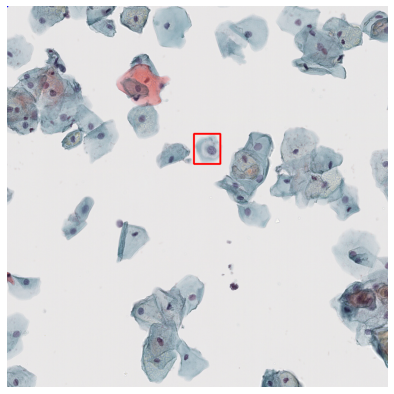

In [25]:
from visualize import visualize
IMAGE_NUM = 1
image = images[IMAGE_NUM].numpy()
image = np.transpose(image, (1, 2, 0))
img_id = targets[IMAGE_NUM]['image_id'].item()
img_path = df[df['ID']==img_id].file_name.values[0]
print(img_path)
ground_boxes = targets[IMAGE_NUM]['boxes']
out_boxes = outputs[IMAGE_NUM]['boxes']
out_scores = outputs[IMAGE_NUM]['scores']
print(out_scores)

pred_boxes = []
for b, s in zip(out_boxes, out_scores) :
    if s > 0.2 :
        pred_boxes.append(b.numpy())

visualize(image, ground_boxes, pred_boxes)        

In [ ]:
df[df['file_name'] == 'patch_images/2021.01.12/LBC308-20210108(1)/LBC308-20210108(1)_1445.png']

In [ ]:
targets